# 卷积神经网络基础

In [1]:
import torch

# torchversion是基于处理图像视频的pytorch包
# torchvision.transforms提供一般的图像转换操作类
from torchvision import transforms
# torchvision.datasets 是用来进行数据加载的
from torchvision import datasets


from torch.utils.data import DataLoader

import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
# 准备数据
 
batch_size = 64
#我们拿到的图片是pillow,我们要把他转换成模型里能训练的tensor也就是张量的格式
# ToTensor()转换为张量，Normalize归一化(均值和方差),都是经验值
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
 
# 训练集
train_dataset = datasets.MNIST(root='../dataset/mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
# 测试集
test_dataset = datasets.MNIST(root='../dataset/mnist/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
 

In [3]:
# 设计模型
 
 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 1是指输入的Channel，每个卷积核的通道数量和输入的通道数量是一样的
        # 10是指输出的Channel，卷积核的数量与输出的通道数量是一样的，要有10个卷积核；
        # 卷积核是1x5x5      
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        #  输入Channel为10；输出Channel为20，要有20个卷积核；卷积核是10x5x5        
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        
        # 下采样（最大池化层）通道数量不变        
        self.pooling = torch.nn.MaxPool2d(2)
        # 做分类用的线性层        
        self.fc = torch.nn.Linear(320, 10)
 
 
    def forward(self, x):
        # flatten data from (batch,1,28,28) to (batch, 784)
        
        batch_size = x.size(0)
        
        # (batch,1,28,28) -> (batch,10,24,24) -> (batch,10,12,12)
        x = F.relu(self.pooling(self.conv1(x)))
        # (batch,10,12,12) -> (batch,20,88) -> (batch,20,4,4)        
        x = F.relu(self.pooling(self.conv2(x)))
        
        # 改变张量形状，获得N*320的矩阵(batch,20,4,4)->(batch,320)
        x = x.view(batch_size, -1) 
        # print("x.shape",x.shape)
        # 320 -> 10         
        x = self.fc(x)
        return x
 
 
model = Net()
# 把计算迁移到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
 

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=320, out_features=10, bias=True)
)

In [4]:
# 构造损失和优化器
# 交叉熵损失 CrossEntropyLoss当训练有多个类别的分类问题时很有效
# CrossEntropyLoss = Softmax + Log + NLLLoss
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)# #lr为学习率

[1,   300] loss: 0.598
[1,   600] loss: 0.201
[1,   900] loss: 0.134
accuracy on test set: 96 % 
[2,   300] loss: 0.111
[2,   600] loss: 0.097
[2,   900] loss: 0.089
accuracy on test set: 98 % 
[3,   300] loss: 0.079
[3,   600] loss: 0.073
[3,   900] loss: 0.070
accuracy on test set: 98 % 
[4,   300] loss: 0.063
[4,   600] loss: 0.064
[4,   900] loss: 0.057
accuracy on test set: 98 % 
[5,   300] loss: 0.056
[5,   600] loss: 0.053
[5,   900] loss: 0.053
accuracy on test set: 98 % 
[6,   300] loss: 0.050
[6,   600] loss: 0.052
[6,   900] loss: 0.045
accuracy on test set: 98 % 
[7,   300] loss: 0.042
[7,   600] loss: 0.047
[7,   900] loss: 0.044
accuracy on test set: 98 % 
[8,   300] loss: 0.039
[8,   600] loss: 0.042
[8,   900] loss: 0.041
accuracy on test set: 98 % 
[9,   300] loss: 0.035
[9,   600] loss: 0.041
[9,   900] loss: 0.039
accuracy on test set: 98 % 
[10,   300] loss: 0.034
[10,   600] loss: 0.032
[10,   900] loss: 0.041
accuracy on test set: 98 % 


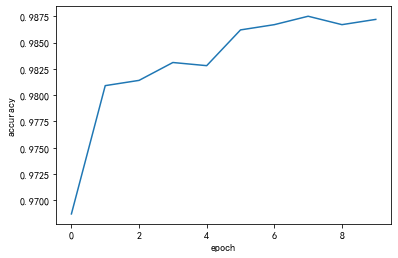

In [5]:
# 训练
 
 
def train(epoch):
    running_loss = 0.0
    # 对于一个可迭代的（iterable）/可遍历的对象（如列表、字符串），enumerate将其组成一个索引序列，利用它可以同时获得索引和值
    # batch_idx显示迭代次数 
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        #  正馈        
        outputs = model(inputs)
        loss = criterion(outputs, target)
        # 反馈        
        loss.backward()
        # 更新权重         
        optimizer.step()
        # 把损失加起来         
        running_loss += loss.item()
        #每300次输出一下数据
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0
 
 
def test():
    correct = 0
    total = 0
    #不用算梯度    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # 我们找每一行最大值的下标             
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('accuracy on test set: %d %% ' % (100*correct/total))
    return correct/total
 
 
if __name__ == '__main__':
    epoch_list = []
    acc_list = []
    
    for epoch in range(10):
        train(epoch)
        acc = test()
        epoch_list.append(epoch)
        acc_list.append(acc)
    
    plt.plot(epoch_list,acc_list)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()
